# Model Choice

Various options considered given hardware constaints (running on Macbook, 16GB RAM):
- Tiny LLaMA
- Phi-1.5
- Pythia 1.4B
- Phi-2 (can possibly tune with QLoRA, but slow)
- Zephyr 1.3B
- Yi-3B (perhaps, with offload)
- Geppetto GP-2

Phi-1.5/2 is a more modern model trained for high performance on reasoning tasks.

TinYLLaMA is a smaller model trained for edge devices, protyping etc.

Pythia is slightly outdated, but it was trained on a more diverse vocabulary from web text and should do better for stylistic text generation like poetry. It was trained on english only text, not ideal for italian text generation.

Zephyr was trained in english, but it's fairly good at text generation

Yi is a more powerful model, trained on some italian partially. Training might be very slow

Gepptetto is a model trained on italian text, but it's old and very outdated.

-------------------------

- Try with Zephyr to start --> it was very slow and could barely fit inside the RAM of the computer.

- I decided to move to TinyLLaMA since it is a smaller model and easier to train on a laptop.



In [19]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import einops
import math
import numpy as np
import matplotlib.pyplot as plt
# Use MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# using the tinyllama model
model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T" #"stabilityai/stablelm-2-zephyr-1_6b"

# Use the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token # add eos_token (not present in the tinyllama tokenizer by default)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"": "mps"},
    torch_dtype="float32",  # mps does not support float16, bfloat16. i wish it did
    trust_remote_code=True
)


In [5]:
# Prepare LoRA with PEFT
from peft import get_peft_model, LoraConfig, TaskType

# LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, # Language modeling
    inference_mode=False, # set to True for inference, False for training
    r=8, # Rank of LoRA matrices. Higher rank gives more capacity to adapt, but is slower and requires more computational resources
    lora_alpha=16, # Scaling factor. Affects how much the LoRA weights "influence" the base model. Typically alpha = 2×r is a good default.
    lora_dropout=0.1 # Dropout during training
)

# Apply LoRA adapters
model = get_peft_model(model, peft_config)

# check that the only trainable parameters are the LoRA ones
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Trainable:", name)


/opt/anaconda3/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Trainable: base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
Trainable: base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
Trainable: base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight
Trainable: base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight
Trainable: base_model.model.model.layers.2.self_attn.q_proj.lora_A.default.weight
Trainable: base_model.model.model.layers.2.self_attn.q_proj.lora_B.default.weight
Trainable: base_model.model.model.layers.2.self_attn.v_proj.lora_A.default.weight
Trainable: base_model.model.model.layers

In [6]:
## create the corpus of text used for training
read_data = False
if read_data: # already have the corpus preprocessed
    with open('corpus_cleaned.txt', 'r', encoding='utf-8') as f:
        corpus = f.read()
else:
    # import the text data
    os.chdir('data')

    corpus = ''
    # read the texts
    for file in ['cavalcanti_poems_cleaned.txt','Dante_Divina_Commedia_final_cleaned.txt','il_canzoniere_petrarca_cleaned.txt']:
        if file.endswith(".txt"):
            text = open(file, 'r', encoding='utf-8').read()
            corpus += text
            # print(text[:100])

    os.chdir('..') # go back 1 lavel higher

In [7]:
from pathlib import Path
import json

# Combine all into one list of canto strings (feeding the model with a nicely formatted data should help it learn better)
def extract_cantos(text):
    cantos = []
    lines = text.strip().splitlines()
    buffer = []
    in_canto = False
    for line in lines:
        if line.strip() == "<canto>":
            buffer = []
            in_canto = True
        elif line.strip() == "</canto>":
            if buffer:
                cantos.append("\n".join(buffer))
            in_canto = False
        elif in_canto:
            buffer.append(line.strip())
    return cantos

need_to_generate_data = False
if need_to_generate_data:
    all_cantos = extract_cantos(corpus)
    # Save as JSONL
    jsonl_path = "italian_poetry_dataset.jsonl"
    with open(jsonl_path, "w", encoding="utf-8") as f:
        for canto in all_cantos:
            json.dump({"text": f"<canto>\n{canto}\n</canto>"}, f, ensure_ascii=False)
            f.write("\n")


In [8]:
## create the dataset
from datasets import load_dataset

# === Load dataset ===
dataset = load_dataset("json", data_files='italian_poetry_dataset.jsonl', split="train")

# === Tokenize the dataset ===
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128) # higher max len could be helpful to improve the ability of the model to maintain coherence over longer context lengths, but it also requires more memory (which is a bottleneck given I am using a laptop)

tokenized_ds = dataset.map(tokenize, batched=True, remove_columns=["text"])

# === Define data collator ===
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# === Training args ===
training_args = TrainingArguments(
    output_dir="./tinyllama-poetry-lora",
    per_device_train_batch_size=1,
    num_train_epochs=5,
    gradient_accumulation_steps=4,
    eval_strategy ="no",
    save_steps=100,
    logging_steps=30,
    fp16=False,
    optim="adamw_torch",
    report_to="none",
    overwrite_output_dir=True
)

print(f"# of training samples: {len(tokenized_ds)}")


Map:   0%|          | 0/476 [00:00<?, ? examples/s]

# of training samples: 476


In [18]:
## test time of training 1 batch
import time
# Set model to train mode
model.train()

# Grab a single example from your tokenized dataset
example = tokenized_ds[0]
input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to("mps")  # shape: [1, seq_len]
attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to("mps")
labels = input_ids.clone()

# Warm-up pass (optional but good for MPS)
for _ in range(2):
    _ = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

# Benchmark
start = time.time()
output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
loss = output.loss
loss.backward()
end = time.time()

print(f"⏱️ One batch (forward + backward) took: {end - start:.2f} seconds")


⏱️ One batch (forward + backward) took: 13.30 seconds


The duration of one batch is about 0.5 seconds on my macbook when things go well. Depending on what else is running, time can vary a lot.

In [9]:
# === Train ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds,
    data_collator=data_collator,
    tokenizer=tokenizer
)

prev_checkpoint = None #"./zephyr-poetry-lora/checkpoint-357"
if prev_checkpoint:
    trainer.train(resume_from_checkpoint=prev_checkpoint)
else:
    trainer.train()

/var/folders/4g/bd8qcn0d0w33my4q6djs6csw0000gn/T/ipykernel_16928/828098516.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
30,4.079700
60,3.957900
90,3.801200
120,3.728300
150,3.693500
180,3.702300
210,3.633100
240,3.627900
270,3.593000
300,3.618300


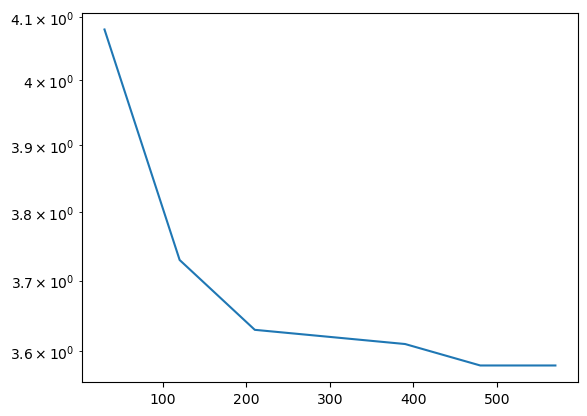

In [22]:
## plot the loss vs step
import matplotlib.pyplot as plt
steps = [30, 120, 210, 300, 390, 480, 570]
losses = [4.08, 3.73, 3.63, 3.62, 3.61, 3.58, 3.58]

plt.semilogy(steps,losses)
plt.show()

In [10]:
## testing the model
# Load base model and tokenizer
model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T" #"stabilityai/stablelm-2-zephyr-1_6b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"": "mps"},
    torch_dtype=torch.float32,
    trust_remote_code=True
)

# Load PEFT configuration and adapter
peft_model = PeftModel.from_pretrained(base_model, "./zephyr-poetry-lora/checkpoint-595")
peft_model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_featu

In [14]:
# custom stopping
from transformers import StoppingCriteria, StoppingCriteriaList

# === Define custom stopping rule
class StopOnCantoEnd(StoppingCriteria):
    def __init__(self, tokenizer, stop_sequence="</canto>"):
        self.tokenizer = tokenizer
        self.stop_ids = tokenizer(stop_sequence, add_special_tokens=False).input_ids

    def __call__(self, input_ids, scores, **kwargs):
        # Check if the last tokens match stop_sequence
        if input_ids.shape[1] < len(self.stop_ids):
            return False
        return (input_ids[0, -len(self.stop_ids):] == torch.tensor(self.stop_ids, device=input_ids.device)).all()


In [16]:
# === Setup generation
prompt = "Inizia il canto:\n<canto>\nNel mezzo del cammin di nostra vita\n"

inputs = tokenizer(prompt, return_tensors="pt").to("mps")

# Attach stopping criteria
stopping_criteria = StoppingCriteriaList([
    StopOnCantoEnd(tokenizer)
])

# === Generate!
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=500,  # Set a safety limit in case model goes crazy
        temperature=1.0,
        top_p=0.95,
        do_sample=True,
        stopping_criteria=stopping_criteria
    )

# === Decode and print
generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("📝 Generated Canto:\n")
print(generated)

📝 Generated Canto:

Inizia il canto:
<canto>
Nel mezzo del cammin di nostra vita
mi sono fermata per dire
che il più triste cor amando,
che la terra vagheggia,
quale mai in sé o in altri
sogna con dolce vista
ch'erel che la vita si farla
m'arrende et inancio
per voler morir nella tua giù?
O meno, ché di noi nessuno son
che non si vada avanti in terra,
ch'ascolta, et la vita che fegleggia,
ch'alzata in alto farli riemper
al di là per cui amà
quello altr'altro et ne' sentir
onde fie ch'ad esser triste
ch'erel che vivi et inancio
che si dever in vita avrebbe?
Non tanto quanto d'ogni gusto
ch'e' per sempre e' 'gni, per
di noi s'ascolta, che son
o mal avendo, o sano altr'altro.
Nell'altra gesto et nell'altro mio
alto s'intorno, et s'invecchio
d'amor, et di paure, et di sciolte
et d'alt'alt'alt'alt'alt'alt'alt'altro;
ché tesserai et a tua luce
d'et non di me, che noi s'innamor
per un'onesta lagrima, et la roba
che i nostri dolci sensi desider,
tanto et sempre ch'e' per sempre
et inancio.
Chi

Not too bad. The text definitely sounds like old italian, and the rough style was transferred. More complex patterns (like the rhyme scheme, keeping things into 'terzina's or the general length of an individual canto) are still missing, perhas using a model with more capacity could help.

In [20]:
### For comparison, the tinyllama without fine tuning would do this:
# === Load the original TinyLlama model
model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"": "mps"},
    torch_dtype=torch.float32,
    trust_remote_code=True
)
model.eval()

# === Prepare the same prompt
prompt = "Inizia il canto:\n<canto>\nNel mezzo del cammin di nostra vita\n"

inputs = tokenizer(prompt, return_tensors="pt").to("mps")

# === Generate without LoRA
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=300,
        temperature=1,
        top_p=0.95,
        do_sample=True
    )

generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("📝 Base TinyLlama Output (No LoRA):\n")
print(generated)

📝 Base TinyLlama Output (No LoRA):

Inizia il canto:
<canto>
Nel mezzo del cammin di nostra vita
Mi prospetto nella penna incorniciata
Di un grande ciondolo di lusso
Da te, lussuriosa eterne stanza,
Vuoi portarmi a fondo nell'imbarazzo?

<re>
Mai avrà la tua voce mai sonoramente
Giunsi a me lanciata al suono d'oro.
Non vi ha in lusso mai avuto l'occhio
A tollerare il malgoverno del mondo?
Se è possibile nella mia sottomissione
Di lusinghe eterne stanzie
Da te come un pezzo di scrittura legna il mio
Nuovo capolavoro, pungente e onesta donna,
Non sevi di questo che te mi piacere,
Il coro, il suono d'alcune vocali

Sui mille angeli da cui ti esce un'alba
Sonore e in pace e in silenzio lontana
M'avete portato a fondo in te,
Come nell'ultimo silenzio, il sole,
In terra eterna e in cielo
Di parole l'oracolo che stanno per dirmi:



<re>
Sono la verità in te, che


The default tinyllama sounds like modern italian, it does not use any of the mannerisms that you would see in old italian poetry. It also capitalizes the first letter of each line, even when it should not. The rhyme scheme is also missing.
We can see that the LoRA helped infuse some of the poetic style into the model. It's still not perfect, but it's a big step forward.